<a href="https://colab.research.google.com/github/shahzebhafeez/ViT_paper_replication/blob/main/PytorchPaperreplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1456), reused 1399 (delta 1399), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 32.23 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path/'train'
test_dir = image_path/'test'

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

print('Manual Transformation of train_image:',manual_transforms)

Manual Transformation of train_image: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
BATCH_SIZE = 32

train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=manual_transforms,
                                                                           batch_size=BATCH_SIZE)

len(train_dataloader),len(test_dataloader),class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
train_batch,label_batch = next(iter(train_dataloader))
image,label = train_batch[0],label_batch[0]
image.shape,label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

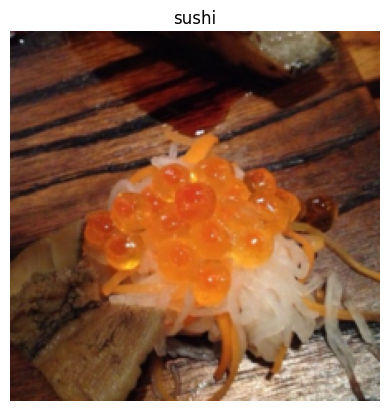

In [9]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [10]:
height= 224
width = 224
color_channels = 3
patch_size = 16

num_patches = int((height*width) // patch_size**2)
print(num_patches)

196


In [11]:
embedding_layer_input_shape = (height,width,color_channels)
embedding_layer_outpur_shape = (num_patches,patch_size**2*color_channels)

print(embedding_layer_input_shape,embedding_layer_outpur_shape)

(224, 224, 3) (196, 768)


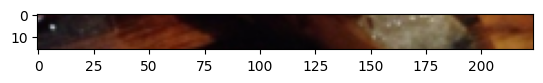

In [12]:
permuted_image = image.permute(1,2,0)
patch_size = 16
patched_image = permuted_image[:patch_size,:,:]
plt.imshow(patched_image)

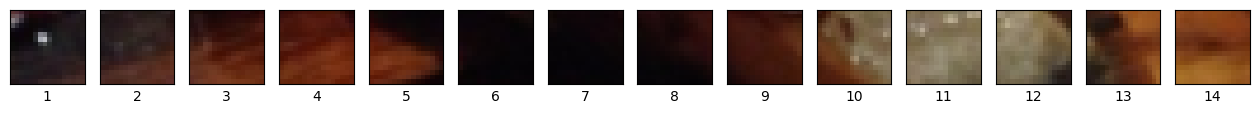

In [13]:
image_size=224
patch_size = 16
num_patches = image_size//patch_size
fig,axs=plt.subplots(nrows=1,
             ncols=num_patches,
             figsize=(patch_size,patch_size),
             sharex=True,
             sharey=True)
for i,patch in enumerate(range(0,image_size,patch_size)):
  axs[i].imshow(permuted_image[:patch_size,patch:patch+patch_size,:])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])


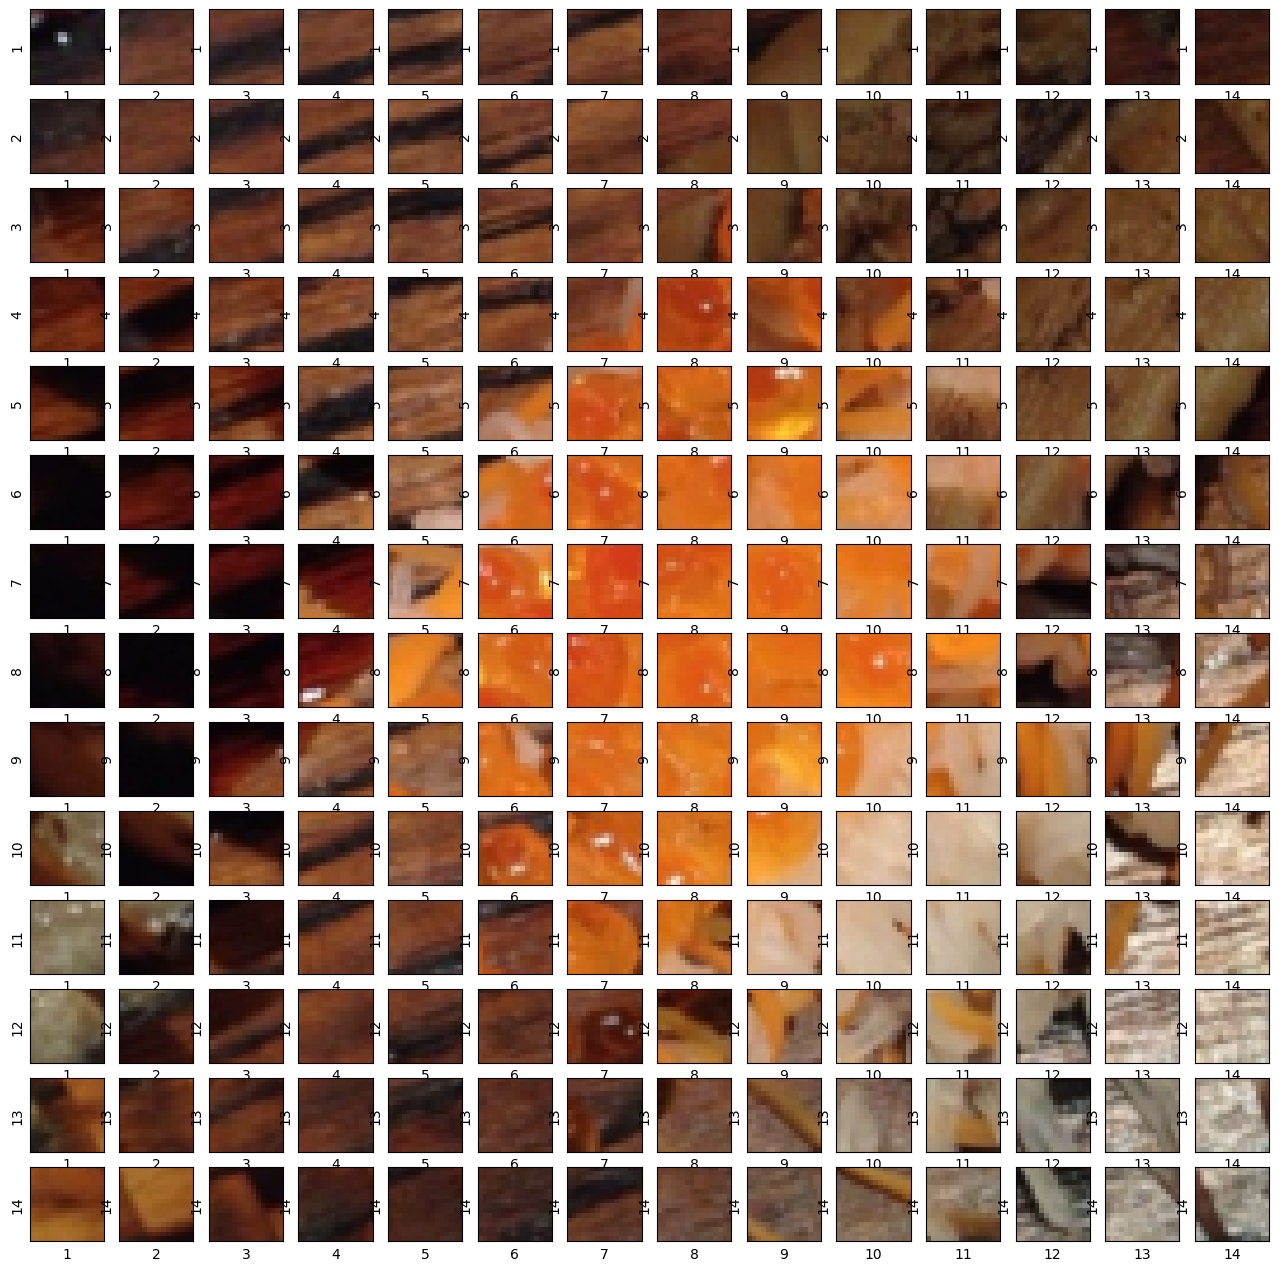

In [14]:
image_size=224
patch_size=16
num_patches= image_size // patch_size

fig,axs=plt.subplots(nrows=num_patches,
             ncols=num_patches,
             figsize=(patch_size,patch_size),
             sharex=True,
             sharey=True)

for i,patch_width in enumerate(range(0,image_size,patch_size)):
  for j,patch_height in enumerate(range(0,image_size,patch_size)):
    axs[i,j].imshow(permuted_image[patch_height:patch_height+patch_size,patch_width:patch_width+patch_size,:])
    axs[i,j].set_ylabel(i+1)
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_yticks([])
    axs[i,j].set_xticks([])

In [15]:
from torch.nn import Conv2d

conv2d = Conv2d(in_channels=3,
       out_channels=768,
       kernel_size=patch_size,
       stride=patch_size,
       padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [16]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


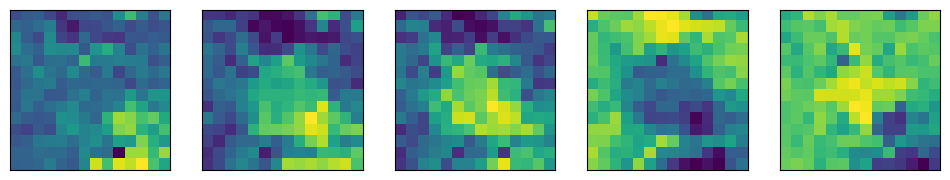

In [17]:
import random
random_indexes = random.sample(range(0, 758), k=5)
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [18]:
from torch import nn
flatten = nn.Flatten(start_dim=2,end_dim=3)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])
torch.Size([1, 768, 196])
torch.Size([768, 196, 1])


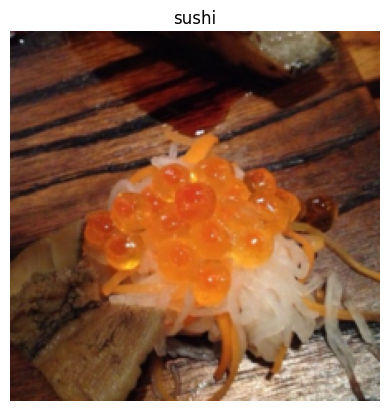

In [19]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
image_out_of_conv = conv2d(image.unsqueeze(0))
flattened_image = flatten(image_out_of_conv)
print(image.shape)
print(image_out_of_conv.shape)
print(flattened_image.shape)
print(flattened_image.permute(1,2,0).shape)


In [20]:
permuted_flattened_image = flattened_image.permute(0,2,1)
plt.imshow(permuted_flattened_image[:,:,0].detach().numpy())
plt.axis(False)


(-0.5, 195.5, 0.5, -0.5)

In [21]:
from torch import nn
class patchEmbedding(nn.Module):
  def __init__(self,
               in_channels=3,
                stride=16,
                filter_size=16,
                out_channels=768):
    super().__init__()
    # 1.conv2d
    self.conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels,
                          kernel_size=filter_size,
                          stride=stride,
                          padding=0)
    # 2.flatten
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
  # 3.forward pass
  def forward(self,x):
    conv_out = self.conv(x)
    flatten_out = self.flatten(conv_out)
    return flatten_out.permute(0,2,1)

In [22]:
patchify = patchEmbedding(in_channels=3,
               stride=16,
               filter_size=16,
               out_channels=768
               )

patched_embedded_img = patchify(image.unsqueeze(0))
print(patched_embedded_img.shape)


torch.Size([1, 196, 768])


In [23]:
#class embedding -> prepend
batch_size=patched_embedded_img.shape[0]
embedding_dim = patched_embedded_img.shape[-1]
class_embedding = torch.nn.Parameter(torch.ones((batch_size,1,embedding_dim)))
print(class_embedding)
print(class_embedding.shape)

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [24]:
#prepend class embedding
final_patched_img = torch.cat((class_embedding,patched_embedded_img),dim=1)
print(final_patched_img,final_patched_img.shape)

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0618,  0.0660, -0.0864,  ...,  0.0909, -0.1548, -0.0218],
         [-0.0481,  0.0701, -0.0996,  ...,  0.0510, -0.2240,  0.1017],
         ...,
         [ 0.0303,  0.0873, -0.4706,  ...,  0.4920, -0.9187,  0.3963],
         [-0.0340,  0.1067, -0.5156,  ...,  0.5007, -0.9165,  0.2830],
         [-0.1150,  0.0199, -0.1874,  ...,  0.3065, -0.6158,  0.3038]]],
       grad_fn=<CatBackward0>) torch.Size([1, 197, 768])


In [25]:
# postion embeddings
patch_size=16
num_patches = int((height*width)/patch_size**2)
embedding_dimension = final_patched_img.shape[2]
position_embedding = torch.nn.Parameter(torch.ones(1,num_patches+1,embedding_dimension),requires_grad=True)
print(position_embedding,position_embedding.shape)

Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True) torch.Size([1, 197, 768])


In [26]:
#adding postion embedding to final_patched_image
pos_embed_patched_img = final_patched_img + position_embedding
print(pos_embed_patched_img,pos_embed_patched_img.shape)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9382, 1.0660, 0.9136,  ..., 1.0909, 0.8452, 0.9782],
         [0.9519, 1.0701, 0.9004,  ..., 1.0510, 0.7760, 1.1017],
         ...,
         [1.0303, 1.0873, 0.5294,  ..., 1.4920, 0.0813, 1.3963],
         [0.9660, 1.1067, 0.4844,  ..., 1.5007, 0.0835, 1.2830],
         [0.8850, 1.0199, 0.8126,  ..., 1.3065, 0.3842, 1.3038]]],
       grad_fn=<AddBackward0>) torch.Size([1, 197, 768])


In [27]:
x = image.unsqueeze(0)
patch_embedding = patchEmbedding(in_channels=3,stride=16,filter_size=16,out_channels=768)
patched_img = patch_embedding(x)
print(f'patched image shape :',patched_img.shape)
batch_size = patched_img.shape[0]
embedding_dimension = patched_img.shape[-1]
patch_size = 16
num_patched = int((height*width)/patch_size**2)
class_embedding = torch.nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
patched_class_img = torch.cat((class_embedding,patched_img),dim=1)
print('patched embedding + class token shape :',patched_class_img.shape)
postion_embedding = torch.nn.Parameter(torch.ones(1,num_patches+1,embedding_dimension),requires_grad=True)
patched_class_pos_img = patched_class_img + position_embedding
print('patched embedding + class token + postition embedding shape :',patched_class_pos_img.shape)

patched image shape : torch.Size([1, 196, 768])
patched embedding + class token shape : torch.Size([1, 197, 768])
patched embedding + class token + postition embedding shape : torch.Size([1, 197, 768])


In [28]:
from torch import nn
class MultiHeadAttention(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:float=0):
     super().__init__()
     self.norm = nn.LayerNorm(normalized_shape=embedding_dim)
     self.MSA = nn.MultiheadAttention(embed_dim=embedding_dim,
                                      num_heads=num_heads,
                                      dropout=attn_dropout,
                                      batch_first=True)
  def forward(self,x):
    x=self.norm(x)
    attn_output,_ = self.MSA(query=x,
                             key=x,
                             value=x,
                             need_weights=False)
    return attn_output


In [29]:
MSA = MultiHeadAttention(embedding_dim=768,
                   num_heads=12,
                   attn_dropout=0)
MSA_out_embeddings = MSA(patched_class_pos_img)
print(patched_class_pos_img.shape,MSA_out_embeddings.shape)

torch.Size([1, 197, 768]) torch.Size([1, 197, 768])


In [30]:
#Equation 3
from torch import nn
class MultiLayerPerceptron(nn.Module):
  def __init__(self,
               embedding_dim=768,
               out_dim=3072,
               dropout=0.1):
     super().__init__()
     self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
     self.MLP = nn.Sequential(
         nn.Linear(in_features=embedding_dim,
                   out_features=out_dim),
         nn.GELU(),
         nn.Dropout(p=dropout),
         nn.Linear(in_features=out_dim,
                   out_features=embedding_dim),
         nn.Dropout(p=dropout)
     )
  def forward(self,x):
    x = self.layer_norm(x)
    x = self.MLP(x)
    return x

In [31]:
MLP = MultiLayerPerceptron(embedding_dim=768,
                           out_dim=3072,
                           dropout=0.1)
MLP_out_embeddings = MLP(MSA_out_embeddings)

print(MLP_out_embeddings.shape)

torch.Size([1, 197, 768])


In [32]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               out_dim:int=3072,
               num_heads:int=12,
               attn_dropout:int=0,
               mlp_dropout:float=0.1):
     super().__init__()
     self.msa_block = MultiHeadAttention(embedding_dim=embedding_dim,
                                         num_heads=num_heads,
                                         attn_dropout=attn_dropout)
     self.mlp_block = MultiLayerPerceptron(embedding_dim=embedding_dim,
                                           out_dim=out_dim,
                                           dropout=mlp_dropout)
  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [33]:
transformer_encoder_block = TransformerEncoderBlock()
summary(model=transformer_encoder_block,
        input_size=(1,197,768),
        )

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderBlock                  [1, 197, 768]             --
├─MultiHeadAttention: 1-1                [1, 197, 768]             --
│    └─LayerNorm: 2-1                    [1, 197, 768]             1,536
│    └─MultiheadAttention: 2-2           [1, 197, 768]             2,362,368
├─MultiLayerPerceptron: 1-2              [1, 197, 768]             --
│    └─LayerNorm: 2-3                    [1, 197, 768]             1,536
│    └─Sequential: 2-4                   [1, 197, 768]             --
│    │    └─Linear: 3-1                  [1, 197, 3072]            2,362,368
│    │    └─GELU: 3-2                    [1, 197, 3072]            --
│    │    └─Dropout: 3-3                 [1, 197, 3072]            --
│    │    └─Linear: 3-4                  [1, 197, 768]             2,360,064
│    │    └─Dropout: 3-5                 [1, 197, 768]             --
Total params: 7,087,872
Trainable params: 7,087,872
Non-tr

In [34]:
torch_transformer_encoder_layer = torch.nn.TransformerEncoderLayer(d_model=768,
                                                                   nhead=12,
                                                                   dim_feedforward=3072,
                                                                   dropout=0.1,
                                                                   activation='gelu',
                                                                   batch_first=True,
                                                                   norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [35]:
from torch import nn
class ViT(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               patch_size:int=16,
               out_dim:int=3072,
               in_channels:int=3,
               num_heads:int=12,
               image_size:int=224,
               attn_dropout:int=0,
               mlp_dropout:float=0.1,
               num_classes:int=1000,
               embedding_dropout:float=0.1,
               transformer_layers:int=12,
                ):
    super().__init__()
    self.num_patches = (image_size * image_size) // patch_size**2
    self.class_embeddings=nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                       requires_grad=True)
    self.position_embeddings=nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),
                                          requires_grad=True)
    self.embedding_dropout=nn.Dropout(p=embedding_dropout)
    self.patch_embedding=patchEmbedding(in_channels=in_channels,
                                        out_channels=embedding_dim)
    self.transformer = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                               out_dim=out_dim,
                                                               num_heads=num_heads,
                                                               mlp_dropout=mlp_dropout) for _ in range(transformer_layers)])
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )
  def forward(self,x):
    batch_size = x.shape[0]
    class_token = self.class_embeddings.expand(batch_size,-1,-1)
    x = self.patch_embedding(x)
    x=torch.cat((class_token,x),dim=1)
    x=self.position_embeddings + x
    x=self.embedding_dropout(x)
    x = self.transformer(x)
    x=self.classifier(x[:,0])
    return x


In [36]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): patchEmbedding(
    (conv): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadAttention(
        (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (MSA): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MultiLayerPerceptron(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (MLP): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): TransformerEncoder

In [37]:
random_img = torch.randn(1,3,224,224)
vit = ViT(num_classes=len(class_names))
print(random_img.device)


cpu


In [38]:
for name, param in vit.named_parameters():
    print(name, param.device)


class_embeddings cpu
position_embeddings cpu
patch_embedding.conv.weight cpu
patch_embedding.conv.bias cpu
transformer.0.msa_block.norm.weight cpu
transformer.0.msa_block.norm.bias cpu
transformer.0.msa_block.MSA.in_proj_weight cpu
transformer.0.msa_block.MSA.in_proj_bias cpu
transformer.0.msa_block.MSA.out_proj.weight cpu
transformer.0.msa_block.MSA.out_proj.bias cpu
transformer.0.mlp_block.layer_norm.weight cpu
transformer.0.mlp_block.layer_norm.bias cpu
transformer.0.mlp_block.MLP.0.weight cpu
transformer.0.mlp_block.MLP.0.bias cpu
transformer.0.mlp_block.MLP.3.weight cpu
transformer.0.mlp_block.MLP.3.bias cpu
transformer.1.msa_block.norm.weight cpu
transformer.1.msa_block.norm.bias cpu
transformer.1.msa_block.MSA.in_proj_weight cpu
transformer.1.msa_block.MSA.in_proj_bias cpu
transformer.1.msa_block.MSA.out_proj.weight cpu
transformer.1.msa_block.MSA.out_proj.bias cpu
transformer.1.mlp_block.layer_norm.weight cpu
transformer.1.mlp_block.layer_norm.bias cpu
transformer.1.mlp_block.M

In [39]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.001,
                             betas=(0.9,0.999))

In [40]:
device

'cuda'

In [41]:
print(next(vit.parameters()).device)


cpu


In [42]:
from going_modular.going_modular import engine
results = engine.train(model=vit,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epochs=10,
             device=device)
print(results)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.4387 | train_acc: 0.2422 | test_loss: 1.3711 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.3208 | train_acc: 0.2617 | test_loss: 1.2574 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1729 | train_acc: 0.2930 | test_loss: 1.0585 | test_acc: 0.4006
Epoch: 4 | train_loss: 1.1313 | train_acc: 0.2773 | test_loss: 1.1546 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.1215 | train_acc: 0.3086 | test_loss: 1.0113 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.1861 | train_acc: 0.2852 | test_loss: 1.2608 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.2132 | train_acc: 0.3281 | test_loss: 1.2008 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1670 | train_acc: 0.3047 | test_loss: 1.1187 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1146 | train_acc: 0.2891 | test_loss: 1.2636 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.1410 | train_acc: 0.2969 | test_loss: 1.0615 | test_acc: 0.2604
{'train_loss': [4.438680350780487, 1.3207529187202454, 1.172922968864441, 1.1312715709209442, 1.1215157955884

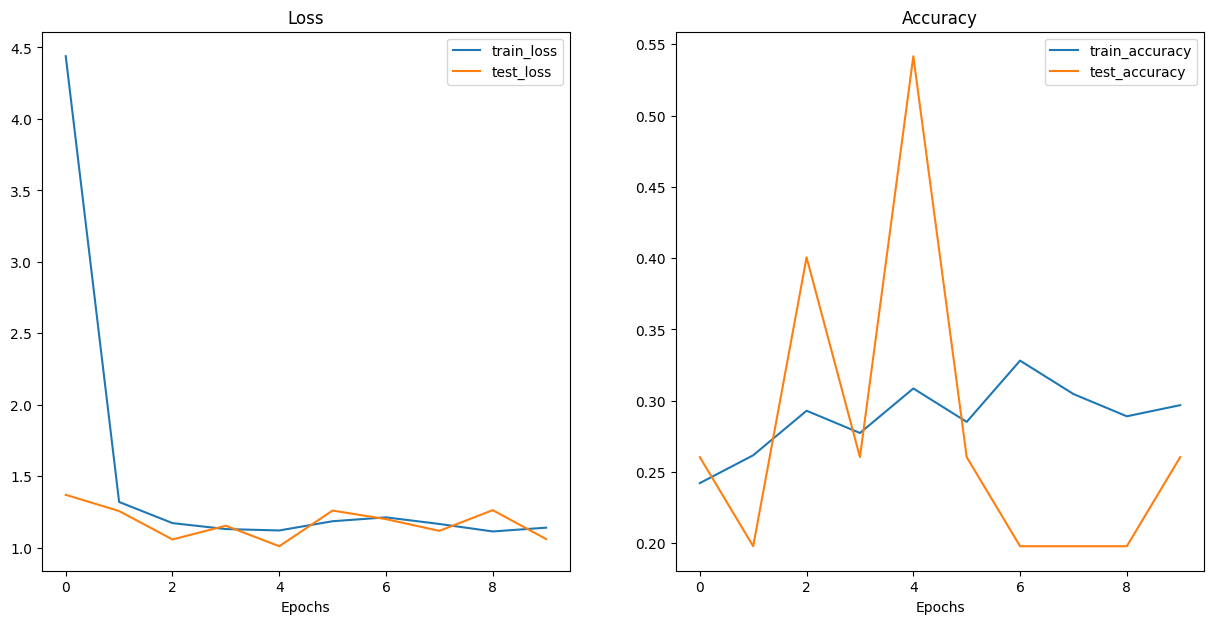

In [43]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [44]:
from torchvision.models import vit_b_16,ViT_B_16_Weights
weights = ViT_B_16_Weights.DEFAULT
print(weights)

ViT_B_16_Weights.IMAGENET1K_V1


In [45]:
pretrained_vit = vit_b_16(weights)
for parameter in pretrained_vit.parameters():
  parameter.requires_grad=False
pretrained_vit.heads = nn.Linear(in_features=768,out_features=len(class_names))
pretrained_vit

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 176MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [46]:
summary(model=pretrained_vit)

Layer (type:depth-idx)                                            Param #
VisionTransformer                                                 768
├─Conv2d: 1-1                                                     (590,592)
├─Encoder: 1-2                                                    151,296
│    └─Dropout: 2-1                                               --
│    └─Sequential: 2-2                                            --
│    │    └─EncoderBlock: 3-1                                     (7,087,872)
│    │    └─EncoderBlock: 3-2                                     (7,087,872)
│    │    └─EncoderBlock: 3-3                                     (7,087,872)
│    │    └─EncoderBlock: 3-4                                     (7,087,872)
│    │    └─EncoderBlock: 3-5                                     (7,087,872)
│    │    └─EncoderBlock: 3-6                                     (7,087,872)
│    │    └─EncoderBlock: 3-7                                     (7,087,872)
│    │    └─EncoderBlo

In [47]:
from going_modular.going_modular import engine
results = engine.train(model=pretrained_vit,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epochs=10,
             device=device)
print(results)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0710 | train_acc: 0.3828 | test_loss: 1.0906 | test_acc: 0.3703
Epoch: 2 | train_loss: 1.0215 | train_acc: 0.5039 | test_loss: 1.0906 | test_acc: 0.3703
Epoch: 3 | train_loss: 1.0312 | train_acc: 0.5039 | test_loss: 1.0906 | test_acc: 0.3703
Epoch: 4 | train_loss: 1.0546 | train_acc: 0.3828 | test_loss: 1.0906 | test_acc: 0.3703
Epoch: 5 | train_loss: 1.0288 | train_acc: 0.5039 | test_loss: 1.0906 | test_acc: 0.3703
Epoch: 6 | train_loss: 1.0475 | train_acc: 0.3828 | test_loss: 1.0906 | test_acc: 0.3703
Epoch: 7 | train_loss: 1.0663 | train_acc: 0.3828 | test_loss: 1.0906 | test_acc: 0.3703
Epoch: 8 | train_loss: 1.0336 | train_acc: 0.5039 | test_loss: 1.0906 | test_acc: 0.3703
Epoch: 9 | train_loss: 1.0855 | train_acc: 0.3828 | test_loss: 1.0906 | test_acc: 0.3703
Epoch: 10 | train_loss: 1.0331 | train_acc: 0.5039 | test_loss: 1.0906 | test_acc: 0.3703
{'train_loss': [1.071012794971466, 1.021505445241928, 1.0312178134918213, 1.0545804351568222, 1.0287885367870

In [48]:
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [49]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [50]:
pretrained_train_dataloader,pretrained_test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                              test_dir=test_dir,
                              transform=transforms,
                              batch_size=32)

In [51]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss = torch.nn.CrossEntropyLoss()
results = engine.train(model=pretrained_vit,
                      train_dataloader=pretrained_train_dataloader,
                      test_dataloader=pretrained_test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=10,
                      device=device)
print(results)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7503 | train_acc: 0.7188 | test_loss: 0.5070 | test_acc: 0.8778
Epoch: 2 | train_loss: 0.3605 | train_acc: 0.9453 | test_loss: 0.2937 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.2047 | train_acc: 0.9531 | test_loss: 0.2258 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.1598 | train_acc: 0.9648 | test_loss: 0.2157 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.1288 | train_acc: 0.9688 | test_loss: 0.2310 | test_acc: 0.8674
Epoch: 6 | train_loss: 0.1089 | train_acc: 0.9766 | test_loss: 0.2273 | test_acc: 0.8674
Epoch: 7 | train_loss: 0.0939 | train_acc: 0.9844 | test_loss: 0.2148 | test_acc: 0.8873
Epoch: 8 | train_loss: 0.0816 | train_acc: 0.9844 | test_loss: 0.2131 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.0815 | train_acc: 0.9883 | test_loss: 0.2068 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.0642 | train_acc: 0.9883 | test_loss: 0.1988 | test_acc: 0.8873
{'train_loss': [0.7503187190741301, 0.3604624383151531, 0.2046733144670725, 0.15984240686520934, 0.1288202583

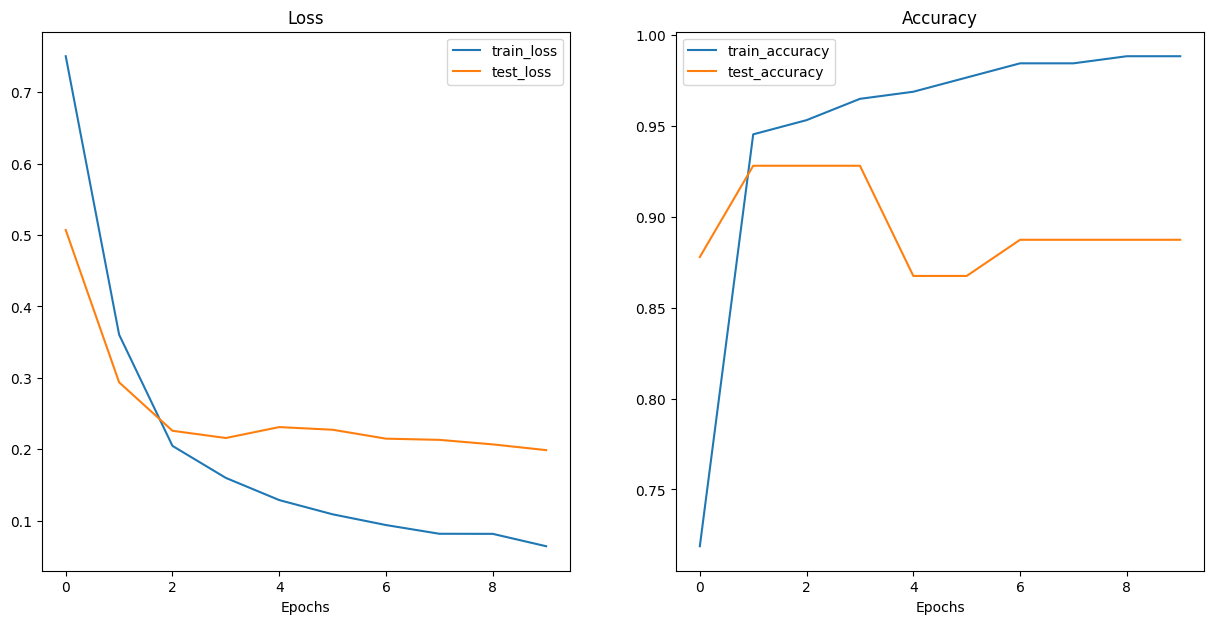

In [52]:
plot_loss_curves(results)

In [53]:
from going_modular.going_modular import utils
utils.save_model(model=pretrained_vit,
                 target_dir='models',
                 model_name='vit_pretrained.pth')

[INFO] Saving model to: models/vit_pretrained.pth


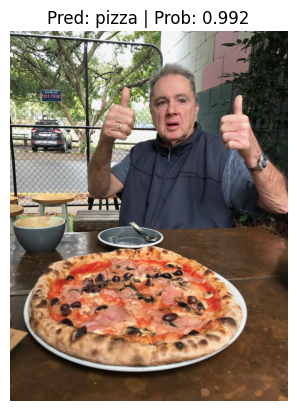

In [54]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)